In [1]:
import modern_robotics as mr
import sympy as sp
from sympy import*
from sympy.physics.mechanics import dynamicsymbols, mechanics_printing
mechanics_printing()
from Utilities.symbolicFunctions import *


# TASK 2

#### 1. Using the original Denavit-Hartenberg convention, determine the Denavit-Hartenberg parameters for the Agilus robot.

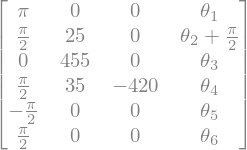

In [2]:
th1, th2, th3, th4, th5, th6 = dynamicsymbols('theta_1, theta_2, theta_3, theta_4, theta_5, theta_6')

config = sp.Matrix([[sp.pi,0,0,th1],[sp.pi/2,25,0,th2 + sp.pi/2],[0,455,0,th3],[sp.pi/2, 35, -420, th4],[-sp.pi/2,0,0,th5],[sp.pi/2, 0, 0,th6]])
config

In [3]:
# oopg 1 Sicilliano
# a alfa    d   v
# sic_conf = sp.Matrix([[0,0,0,th1], [25,sp.pi/2,0,th2+sp.pi/2], [455,0,0,th3], [35,sp.pi/2,-420,th4], [0,-sp.pi/2,0,th5], [0,sp.pi/2,-80,th6]])
# sic_conf

#### 2. Determine the end-effector zero position configuration M ∈ SE(3) for the Agilus robot

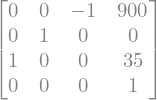

In [4]:
Mi = sp.Matrix([[sp.eye(4)]*6])

for i in range(6):
    if i == 2:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) * rotZ(-sp.pi/2) # We compansate for the rotation of -pi/2 done when finding the D-H parameters 
    else:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2])

M = sp.eye(4)
for n in range(5,-1,-1):
    M = Mi[:,4*n:4*(n+1)] * M

M

In [5]:
# oppg 2 # Snart siciliano
# Mi = sp.Matrix([[sp.eye(4)]*6])

# for i in range(6):
#     if i == 1:
#         Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) #* rotZ(-sp.pi/2) # We compansate for the rotation of -pi/2 done when finding the D-H parameters 
#     else:
#         Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2])

# M = sp.eye(4)
# for n in range(5,-1,-1):
#     M = Mi[:,4*n:4*(n+1)] * M


# M

#### 3. Determine the space frame screw axes Si for the Agilus robot.

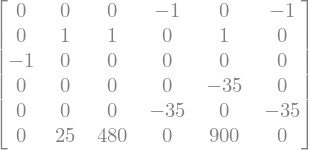

In [6]:
Ai = sp.Matrix([[0,-1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]) # This is a given matrix due to revolute joints

S_sp = sp.zeros(6)
for i in range(6):
    dot_sum = sp.eye(4)
    for n in range(i,-1,-1):
        dot_sum = Mi[:,4*n:4*(n+1)] * dot_sum
    S_skew = dot_sum * Ai * sp.Inverse(dot_sum)
    S_sp[0,i] = S_skew[2,1] 
    S_sp[1,i] = S_skew[0,2] 
    S_sp[2,i] = S_skew[1,0] 
    S_sp[3,i] = S_skew[0,3] 
    S_sp[4,i] = S_skew[1,3]
    S_sp[5,i] = S_skew[2,3] 

S_sp

#### 4. Determine the body-frame screw axes Bi for the Agilus robot

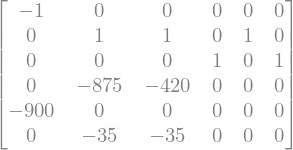

In [7]:
M_inv = mr.TransInv(M)          #Finding inverse of M
Ad_M_inv = mr.Adjoint(M_inv)    #Computing [Ad_M^-1]

#Using B_i = [Ad_M^-1]S_i
S_bp = sp.zeros(6,6)
for i in range(6):
     S_bp[:, i] = Ad_M_inv * S_sp[:, i]

S_bp

### 5. Visualization 
#### Visualization using custom class in Utilities module. The big coordinate system being the {s}-frame and joint-frames oriented with z-axis along joint screw-axis.
#### Axis colours:
####    -Blue   -Z axis and joint screw-axis
####    -Red    -X axis
####    -Green  -Y axis

In [1]:
from Utilities.RobotClass import*
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [9]:
#DH frames:

#Finding T01, T02..., from DH formulation Mi
Tlist_DH = np.zeros((6,4,4))      

T = sp.eye(4)
for i in range(6):          
    T = T * Mi[:,4*i:4*(i+1)]
    Tlist_DH[i] = T

#Visualize frames
Kuka_DH = Robot(Tlist_DH,['x','x','x','y','z','z'])
Kuka_DH.joints[5].set_colour([1,0,0])
Kuka_DH.draw_robot()


WebVisualizer(window_uid='window_0')

In [11]:
#Kuka robot visualized in zero-config, showing M (red) and all Screw axes as the joint frames' z-axis.
from Utilities.kukaKinematics import Mlist, Slist, Tnb

Kuka = Robot(Mlist, ['z', '-z', 'x', 'x', '-z','x'], Tnb) # With endeffector offset by Tnb

In [12]:
Kuka.joints[5].set_colour([1,0,0])
Kuka.draw_robot()

WebVisualizer(window_uid='window_3')